# Logistic Regression Trading Signal
by Michal Plewnia

This code provides an example of how one can apply machine learning techniques to generate trading signal. Presented technique would involve applying logistic regression model to predict wether the market movements would be UP or DOWN.

To determine if the market would go up or down, the model will use laggged returns as a feature to predict market movements. 

Logistic Regression returns as an output binary dependent variable. Basic algorithm would work as follow:
- If predicted value is 1, it is a **LONG** signal (model predicts that market will move up) - in other word buy signal,
- If predicted value is -1, it is a **SHORT** signal (model predicts that market will go down) - in other words sell signal.

Tested instrument would be **S&P 500 E-mini** futures contract (ticker: ES=F).

## Importing necessary libraries

In [113]:
import yfinance as yf
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

## Downloading and preparing the data

We will use the <code>yfinance</code> library to get the prices of the E-mini futures contract. The closing prices of the contract would be used to provide the signal and calculate returns.

In [122]:
df = yf.download('ES=F', start = "2012-01-01", end = '2022-12-30')

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1274.75,1280.00,1270.25,1272.00,1272.00,1565370
2012-01-04,1272.00,1274.75,1262.75,1273.00,1273.00,1419339
2012-01-05,1273.25,1278.00,1259.75,1273.00,1273.00,1819520
2012-01-06,1273.25,1282.25,1266.75,1274.25,1274.25,1691991
2012-01-09,1274.75,1277.75,1267.25,1275.50,1275.50,1438170


In [123]:
# calculate returns of the the close prices
df['r'] = np.log(df.Close.pct_change() + 1)


## Lagged returns function

In order to get the lagged returns for the same time index, it is necessary to build a function that will pull lagged returns and append it to the current day.

In [24]:
def laggs(df, lags):
    for i in range(1, lags +1): # +1, otherwise we will have one less iteration
        df['lag_' + str(i)] = df['r'].shift(i)
    return ['lag_' + str(i) for i in range(1, lags+1)]

## How many lags to implement?

In order to determine how many lags would be appropiate for the model, we will use the autocorrelation function (ACF). The ACF will help to identify how correlated the values in a time series are with each other. This will tell you how much impact previous values of a time-series can have on a current value. To visualize the result, it is possible to use <code>plot_acf</code> from <code>statsmodels</code> package.

<Figure size 2000x1000 with 0 Axes>

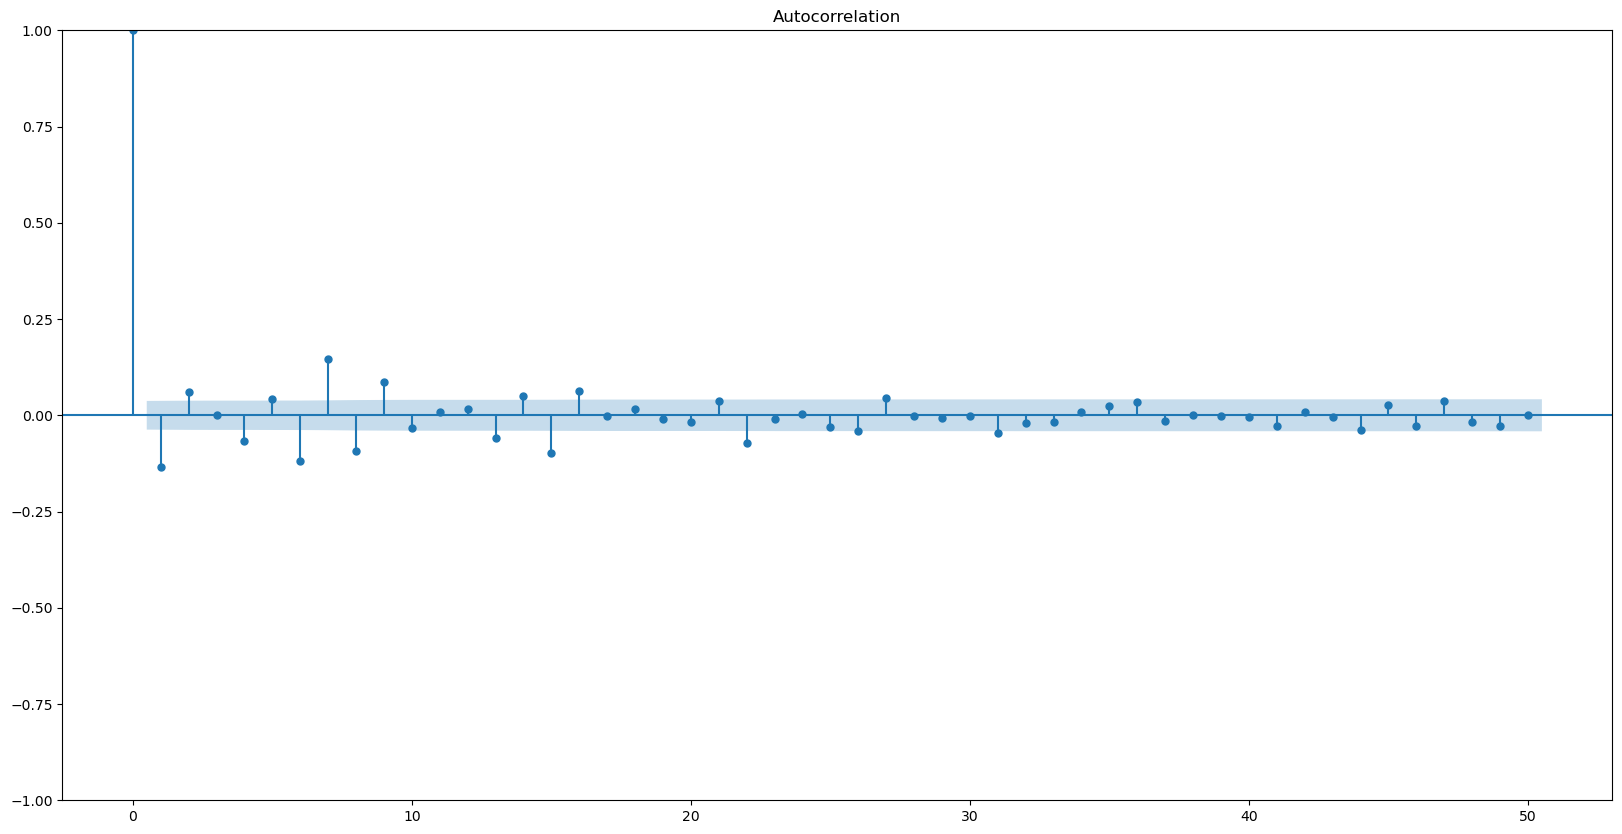

In [124]:
returns = df['r'].dropna()

r_arr = returns.to_numpy()
r_arr

plt.rc("figure", figsize = (20,10))
plt.figure(figsize = (20,10))
plot_acf(r_arr, lags = 50)
plt.show()

It is possible to see that the 1st & 2nd lags are correlated and provide small, but valuable information. 3rd lagged returns start to provide almost 0 information for impacting the present value. Further laggs (5th, 6th and 7th) are also correlated. It could be effect for the performance of the stock during the previous week, which market would follow.

Since weekly stock performance seems reasonable, we will try to account for that in the model, therefore we will use 5 lags as a feature to the model.

In [125]:
# apply the laggs function to the dataset
laggs(df, 5)

df.head(10)

,Open,High,Low,Close,Adj Close,Volume,r,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,,,,,
2012-01-03,1274.75,1280.00,1270.25,1272.00,1272.00,1565370,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,1272.00,1274.75,1262.75,1273.00,1273.00,1419339,0.000786,NaN,NaN,NaN,NaN,NaN
2012-01-05,1273.25,1278.00,1259.75,1273.00,1273.00,1819520,0.000000,0.000786,NaN,NaN,NaN,NaN
2012-01-06,1273.25,1282.25,1266.75,1274.25,1274.25,1691991,0.000981,0.000000,0.000786,NaN,NaN,NaN
2012-01-09,1274.75,1277.75,1267.25,1275.50,1275.50,1438170,0.000980,0.000981,0.000000,0.000786,NaN,NaN
2012-01-10,1275.00,1292.00,1274.50,1286.00,1286.00,1531383,0.008198,0.000980,0.000981,0.000000,0.000786,NaN
2012-01-11,1286.00,1289.50,1279.25,1288.25,1288.25,1800297,0.001748,0.008198,0.000980,0.000981,0.000000,0.000786
2012-01-12,1288.25,1297.50,1280.75,1291.75,1291.75,1755528,0.002713,0.001748,0.008198,0.000980,0.000981,0.000000
2012-01-13,1292.00,1295.00,1272.75,1289.00,1289.00,2115831,-0.002131,0.002713,0.001748,0.008198,0.000980,0.000981


In [126]:
# set binary direction 
df['dir'] = np.where(df.r > 0, 1, -1)

df

,Open,High,Low,Close,Adj Close,Volume,r,lag_1,lag_2,lag_3,lag_4,lag_5,dir
Date,,,,,,,,,,,,,
2012-01-03,1274.75,1280.00,1270.25,1272.00,1272.00,1565370,NaN,NaN,NaN,NaN,NaN,NaN,-1
2012-01-04,1272.00,1274.75,1262.75,1273.00,1273.00,1419339,0.000786,NaN,NaN,NaN,NaN,NaN,1
2012-01-05,1273.25,1278.00,1259.75,1273.00,1273.00,1819520,0.000000,0.000786,NaN,NaN,NaN,NaN,-1
2012-01-06,1273.25,1282.25,1266.75,1274.25,1274.25,1691991,0.000981,0.000000,0.000786,NaN,NaN,NaN,1
2012-01-09,1274.75,1277.75,1267.25,1275.50,1275.50,1438170,0.000980,0.000981,0.000000,0.000786,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,3915.00,3919.75,3788.50,3849.25,3849.25,1842326,-0.014572,0.014572,0.000975,-0.006731,-0.006573,-0.025587,-1
2022-12-23,3850.00,3872.50,3821.25,3869.75,3869.75,1374913,0.005312,-0.014572,0.014572,0.000975,-0.006731,-0.006573,1
2022-12-27,3878.00,3900.50,3837.25,3855.00,3855.00,1006414,-0.003819,0.005312,-0.014572,0.014572,0.000975,-0.006731,-1


In [127]:
df['dir'].value_counts()

 1    1502
-1    1265
Name: dir, dtype: int64

There's slight imbalance, so it might affect the regression results.

## Model setup

Having the data, it is possible to set up a model.  We will start by providing the lags as a feautre, create train-test split and evaluate the model performance later.

In [128]:
# set-up the features

features = laggs(df,5)

features

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

In [129]:
df.dropna(inplace = True)

In [130]:
# set-up a logistic regression model

model = LogisticRegression(class_weight = 'balanced')

In [131]:
# setup the fatures (X variables) and dependet variable (y output)
X = df[features]
y = df['dir']

# perform a test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,
                                                   shuffle = False)

In [132]:
#fit the model
model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

## Prediction & model evaluation

Once the instance of model is prepared, we can start by making the prediction. After the prediction, it is important to evaluate the model, using standard methods such as confusion marix, classification report and checking for the model's score.

### Prediction

In [133]:
# model prediction
prediction = model.predict(X_test)

### Evaluation

In [134]:
# confusion matrix
print(metrics.confusion_matrix(y_test, prediction))

[[181 144]
 [189 177]]


In [135]:
# classification report
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

          -1       0.49      0.56      0.52       325
           1       0.55      0.48      0.52       366

    accuracy                           0.52       691
   macro avg       0.52      0.52      0.52       691
weighted avg       0.52      0.52      0.52       691



In [136]:
# model accuracy (score)
model.score(X_test, y_test)

0.5180897250361794

### Analysis of the model accuracy

**Confusion matrix**
The confusion matrix helps to understand how many values from the sample were actually predicted correctly. From the table we can see that the model predicted correctly 181 down movements and 177 times up movements. Table below shows how to interpret the results:

|x | Predicted: -1 | Predicted : 1 |
|--:|---:---|---:---|
|**Actual: -1**| 181 | 144 |
|**Actual: 1**| 189 | 177 |

**Classification report**

LONG predictions were more precise than SHORT predictions. The <code>f1-score</code> for both -1 and 1 signals were 0.52.

**Model accuracy**

The accuracy of the model is close to 52%. Therefore, it is able to predict more than a half values correctly.


## Strategy performance based on the Logistic Regression

Once the model was validates and its accuracy was tested, it is possible to check how the trading strategy would work based off the model. At first, we will store in the <code>X_test</code> DataFrame <code>LR_pred</code> values the prediction from <code>model.predict()</code>. Then, the returns <code>r</code> from the initial DataFrame would be stored in the <code>X_test</code>. Next, the returns for the signal would be calculated and at the end we will evaluate if the strategy was able to outperform the buy and hold for the out-of-sample period.

In [137]:
# store the signals
X_test['LR_pred'] = model.predict(X_test)

In [138]:
# store the returns in the tested sample

X_test['r'] = df.r[X_test.index[0]:]

X_test

,lag_1,lag_2,lag_3,lag_4,lag_5,LR_pred,r
Date,,,,,,,
2020-04-07,0.063115,-0.013502,0.027598,-0.048537,-0.016020,-1,-0.000946
2020-04-08,-0.000946,0.063115,-0.013502,0.027598,-0.048537,1,0.034595
2020-04-09,0.034595,-0.000946,0.063115,-0.013502,0.027598,-1,0.016230
2020-04-13,0.016230,0.034595,-0.000946,0.063115,-0.013502,-1,-0.007402
2020-04-14,-0.007402,0.016230,0.034595,-0.000946,0.063115,1,0.029901
...,...,...,...,...,...,...,...
2022-12-22,0.014572,0.000975,-0.006731,-0.006573,-0.025587,-1,-0.014572
2022-12-23,-0.014572,0.014572,0.000975,-0.006731,-0.006573,1,0.005312
2022-12-27,0.005312,-0.014572,0.014572,0.000975,-0.006731,-1,-0.003819


In [139]:
# calculate returns from the predicted values
X_test['lr_signal'] = X_test['LR_pred'] * X_test['r']

In [142]:
# cumulative returns from the strategy and buy and hold
(X_test[['lr_signal','r']] + 1).cumprod()

,lr_signal,r
Date,,
2020-04-07,1.000946,0.999054
2020-04-08,1.035574,1.033617
2020-04-09,1.018767,1.050392
2020-04-13,1.026308,1.042617
2020-04-14,1.056995,1.073792
...,...,...
2022-12-22,1.472924,1.380148
2022-12-23,1.480747,1.387479
2022-12-27,1.486402,1.382180


<AxesSubplot:xlabel='Date'>

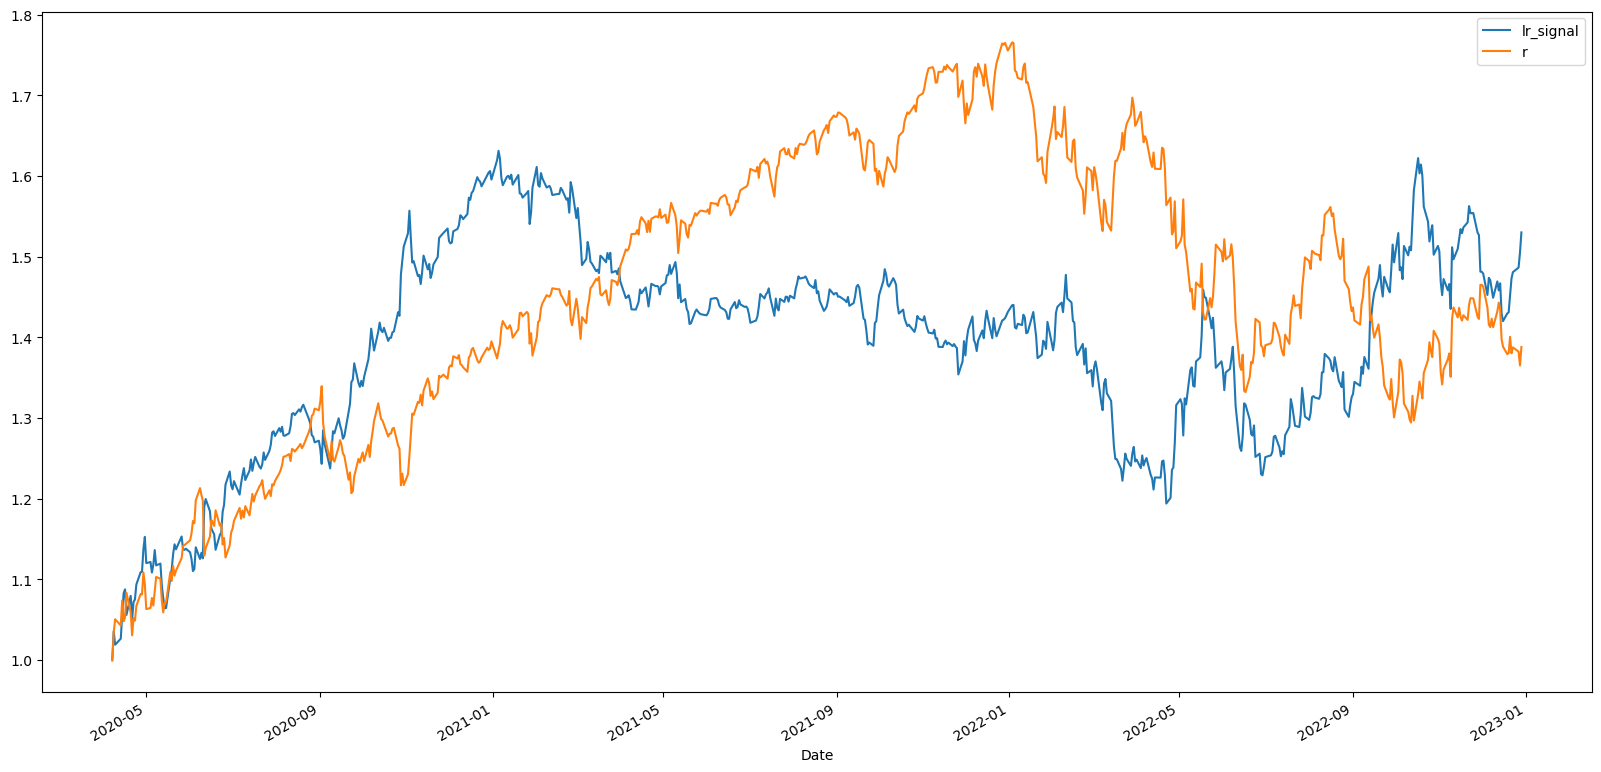

In [145]:
# plotting the resutls
(X_test[['lr_signal','r']] + 1).cumprod().plot()

## Conclusion

The strategy was able to **slightly outperform the market**.

Between 2020-05 and approx. 2021-05 the model was quite accurate, because it provided good signals for the strategy. After 2021-05 until 2022-05 the strategy did not perform well, the cumulative returns were smaller than buy and hold. For the last months the strategy started to outperform the market as well.

## Possible extenstions of the model

The model was an example of how one can apply the Linear Regression model to make the predictions of the time-series movements in the future. However, there are various steps one can make to make the model better:
1. **Different time frame**: depending on the time frame, the strategy can work better or worse. In this particular case it was able to outperform the market, but changing the time frame or test size would impact the results as well (positively or negtively).
2. **Different number of lags**: The strategy could be tested for different number of lags. Since the lags statistical significance was not fully robust (i.e third lag was not significant, and the decay was not "proportional"), different lags could work as well. Those can be selected based of the ACF function or even randomly.
3. **Different price taken for prediction**: In this strategy, major simplification was done - the Closing price was used for both prediction and the price for the buy or sell. Alternatively, the prediction could be done on average daily price.